# JULIA POMDP

### Introduction to Julia

The programming language Julia is a dynamic language, suitable for scientific and numerical computing. Some features that make Julia interesting are the JIT (Just In Time) compiler, the possibility of calling other libraries written in C, Fortran or Python and the native support of different types of systems such as scalars, vectors, arrays, tuples and the possibility of define others using the language itself.

### POMDPs.jl
The POMDPs.jl package contains the interface used to express and solve Markov decision making (MDP) and partially observable Markov decision making (POMDP) ​​in the Julia programming language.

It is a general interface capable of handling problems with discrete and continuous state / action / observation spaces, number of well-known state-of-the-art solvers available for use out of the box, tools that make problem definition and simulation of solutions simple and simple integration of custom solvers into the existing interface

## CASE STUDY
This problem describes a situation in which an agent is placed in front of two closed doors. Behind one of the doors is a tiger and behind the other is a reward. If the agent opens the door with the tiger, then a
you receive a penalty.
A further action that is granted to the agent is to listen in order to obtain information on the tiger's position, but listening costs the agent and is not entirely accurate.

Actions: left, right and listen

The reward for opening the correct door is +10 and the penalty for choosing the door with the tiger behind it is -100, plus the cost of listening is −1.

In [1]:
using POMDPs
using POMDPModels
using QuickPOMDPs
using POMDPPolicies
using BeliefUpdaters
using POMDPModelTools
using POMDPSimulators 
using QuickPOMDPs
using Plots
using QMDP
using FIB
using IncrementalPruning


m = QuickPOMDP(
    states = [:left, :right],
    actions = [:left, :right, :listen],
    observations = [:left, :right],
    initialstate = Uniform([:left, :right]),
    discount = 0.95,

    transition = function (s, a)
        if a == :listen
            return Deterministic(s) # tiger stays behind the same door
        else # a door is opened
            return Uniform([:left, :right]) # reset
        end
    end,

    observation = function (s, a, sp)
        if a == :listen
            if sp == :left
                return SparseCat([:left, :right], [0.85, 0.15]) # sparse categorical distribution
            else
                return SparseCat([:right, :left], [0.85, 0.15])
            end
        else
            return Uniform([:left, :right])
        end
    end,

    reward = function (s, a, sp, o...) # QMDP needs R(s,a,sp), but simulations use R(s,a,sp,o)
        if a == :listen  
            return -1.0
        elseif s == a # the tiger was found
            return -100.0
        else # the tiger was escaped
            return 10.0
        end
    end
)

QuickPOMDP{UUID("93a926ee-16dd-422b-9b3f-32fb74177cec"),Symbol,Symbol,Symbol,NamedTuple{(:stateindex, :isterminal, :obsindex, :states, :observations, :discount, :actions, :observation, :actionindex, :initialstate, :transition, :reward),Tuple{Dict{Symbol,Int64},Bool,Dict{Symbol,Int64},Array{Symbol,1},Array{Symbol,1},Float64,Array{Symbol,1},var"#2#5",Dict{Symbol,Int64},Uniform{Set{Symbol}},var"#1#4",var"#3#6"}}}((stateindex = Dict(:left => 1,:right => 2), isterminal = false, obsindex = Dict(:left => 1,:right => 2), states = [:left, :right], observations = [:left, :right], discount = 0.95, actions = [:left, :right, :listen], observation = var"#2#5"(), actionindex = Dict(:left => 1,:right => 2,:listen => 3), initialstate = Uniform{Set{Symbol}}(Set([:left, :right])), transition = var"#1#4"(), reward = var"#3#6"()))

## QMDP

QMDP is a simple, but fast approximate planner for POMDP problems. Instead of adopting belief states (uncertainty about the correct state), the QMDP algorithm assumes full observability by temporarily ignore the observation model and find the QMDP(s; a) values for the MDP consisting of the transitions and rewards only.

First initialize the alpha vectors α<sub>a</sub><sup>0</sup> = 0 for all states, then iterate:
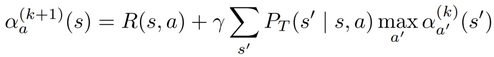

After a sufficient number of iterations, the alpha vectors converge to the QMDP approximation.

In [2]:
solver_QMDP = QMDPSolver()
policy_QMDP = solve(solver_QMDP, m)

rsum = 0.0
c = 1

for (s,b,a,o,r) in stepthrough(m, policy_QMDP, "s,b,a,o,r", max_steps=10)
    println("STEP $c: tiger state $s, b: $([pdf(b,s) for s in states(m)]), action: $a, observation: $o, reward: $r")
    global rsum += r
    global c += 1
end
print("\nUndiscounted reward is $rsum.\n\n")

print("Policy:\n")
for v in alphapairs(policy_QMDP)
    print(v, "\n")
end
print("\n")

STEP 1: tiger state left, b: [0.5, 0.5], action: listen, observation: left, reward: -1.0
STEP 2: tiger state left, b: [0.85, 0.15], action: listen, observation: left, reward: -1.0
STEP 3: tiger state left, b: [0.9697986577181208, 0.0302013422818792], action: right, observation: left, reward: 10.0
STEP 4: tiger state right, b: [0.5, 0.5], action: listen, observation: right, reward: -1.0
STEP 5: tiger state right, b: [0.15, 0.85], action: listen, observation: right, reward: -1.0
STEP 6: tiger state right, b: [0.0302013422818792, 0.9697986577181208], action: left, observation: right, reward: 10.0
STEP 7: tiger state right, b: [0.5, 0.5], action: listen, observation: right, reward: -1.0
STEP 8: tiger state right, b: [0.15, 0.85], action: listen, observation: right, reward: -1.0
STEP 9: tiger state right, b: [0.0302013422818792, 0.9697986577181208], action: left, observation: right, reward: 10.0
STEP 10: tiger state left, b: [0.5, 0.5], action: listen, observation: left, reward: -1.0

Undis

POMDP policies can be represented as a set of alpha vectors. Each alpha vector corresponds to an action and has as many elements as there are states. The utility of a belief state is the maximum value of V(b) = max<sub>αi</sub> b · αi.

By construction, each of the α-vectors is maximum over a part of space; space is subdivided according to which α-vector is maximum in that region.

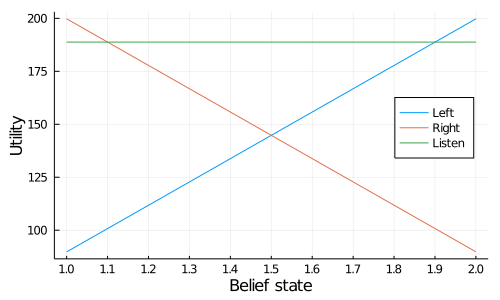

In [3]:
alphavector = alphavectors(policy_QMDP)
plot(alphavector, size=(500, 300), xlabel = "Belief state", ylabel = "Utility", legend=:right, label = ["Left" "Right" "Listen"], xticks = 0:0.1:2)

## FIB

Fast Informed Bound (FIB) is able to take into account (to some degree) the partial observability of the environment.
Like QMDP, FIB algorithm creates one α-vector per action, and they are initialized to zero. The update rule of FIB is:
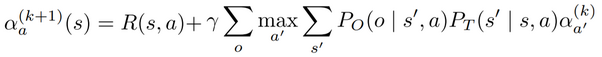

In [4]:
solver_FIB = FIBSolver()
policy_FIB = solve(solver_FIB, m)

rsum = 0.0
c = 1

for (s,b,a,o,r) in stepthrough(m, policy_FIB, "s,b,a,o,r", max_steps=10)
    println("STEP $c: tiger state $s, b: $([pdf(b,s) for s in states(m)]), action: $a, observation: $o, reward: $r")
    global rsum += r
    global c += 1
end
print("\nUndiscounted reward is $rsum.\n\n")

print("Policy:\n")
for v in alphapairs(policy_FIB)
    print(v, "\n")
end

STEP 1: tiger state left, b: [0.5, 0.5], action: listen, observation: left, reward: -1.0
STEP 2: tiger state left, b: [0.85, 0.15], action: listen, observation: right, reward: -1.0
STEP 3: tiger state left, b: [0.5, 0.5], action: listen, observation: left, reward: -1.0
STEP 4: tiger state left, b: [0.85, 0.15], action: listen, observation: left, reward: -1.0
STEP 5: tiger state left, b: [0.9697986577181208, 0.0302013422818792], action: right, observation: left, reward: 10.0
STEP 6: tiger state left, b: [0.5, 0.5], action: listen, observation: left, reward: -1.0
STEP 7: tiger state left, b: [0.85, 0.15], action: listen, observation: left, reward: -1.0
STEP 8: tiger state left, b: [0.9697986577181208, 0.0302013422818792], action: right, observation: left, reward: 10.0
STEP 9: tiger state right, b: [0.5, 0.5], action: listen, observation: right, reward: -1.0
STEP 10: tiger state right, b: [0.15, 0.85], action: listen, observation: right, reward: -1.0

Undiscounted reward is 12.0.

Policy:

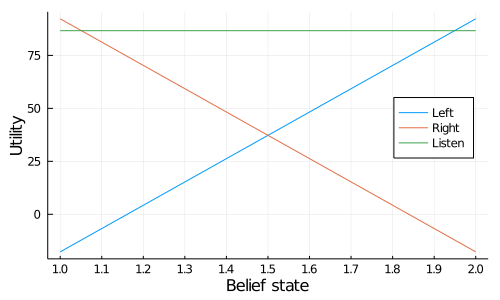

In [5]:
alphavector = alphavectors(policy_FIB)
plot(alphavector, size=(500, 300), xlabel = "Belief state", ylabel = "Utility", legend=:right, label = ["Left" "Right" "Listen"], xticks = 0:0.1:2)


## INCREMENTAL PRUNING

A set of linear action-value functions are stored as vectors representing the policy. In each iteration of running algorithm, the current policy  is transformed into a new set of vectors and then they are filtered. The cycle is repeated for some fixed number of iterations, or until the value function converges to a stable set of vectors.

It is based on the following formula:
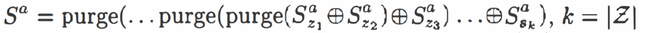

In [6]:
solver_IP = PruneSolver()
policy_IP = solve(solver_IP, m)

rsum = 0.0
c = 1

for (s,b,a,o,r) in stepthrough(m, policy_IP, "s,b,a,o,r", max_steps=10)
    println("STEP $c: tiger state $s, b: $([pdf(b,s) for s in states(m)]), action: $a, observation: $o, reward: $r")
    global rsum += r
    global c += 1
end
print("\nUndiscounted reward is $rsum.\n\n")

print("Policy:\n")
for v in alphapairs(policy_IP)
    print(v, "\n")
end

STEP 1: tiger state right, b: [0.5, 0.5], action: listen, observation: right, reward: -1.0
STEP 2: tiger state right, b: [0.15, 0.85], action: listen, observation: right, reward: -1.0
STEP 3: tiger state right, b: [0.0302013422818792, 0.9697986577181208], action: left, observation: right, reward: 10.0
STEP 4: tiger state left, b: [0.5, 0.5], action: listen, observation: left, reward: -1.0
STEP 5: tiger state left, b: [0.85, 0.15], action: listen, observation: left, reward: -1.0
STEP 6: tiger state left, b: [0.9697986577181208, 0.0302013422818792], action: right, observation: left, reward: 10.0
STEP 7: tiger state right, b: [0.5, 0.5], action: listen, observation: right, reward: -1.0
STEP 8: tiger state right, b: [0.15, 0.85], action: listen, observation: right, reward: -1.0
STEP 9: tiger state right, b: [0.0302013422818792, 0.9697986577181208], action: left, observation: right, reward: 10.0
STEP 10: tiger state left, b: [0.5, 0.5], action: listen, observation: left, reward: -1.0

Undis

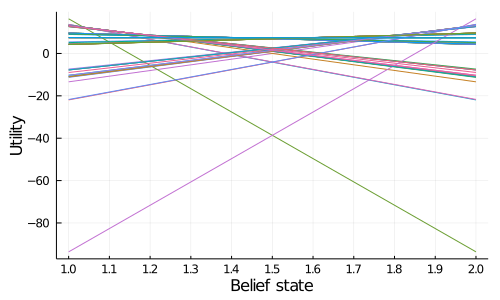

In [7]:
alphavector = alphavectors(policy_IP)
plot(alphavector, size=(500, 300), xlabel = "Belief state", ylabel = "Utility", legend=false, xticks = 0:0.1:2)

#### _References:_
_Julia language https://julialang.org/_ <br/>
_POMDPs and POMDP solvers https://github.com/JuliaPOMDP/POMDPs.jl_ <br/>
_POMDPs.jl http://juliapomdp.github.io/POMDPs.jl/stable/_ <br/>
_"Learning policies for partially observable environments: Scaling up" - Littman, Cassandra,  Kaelbling_ <br/>
_"Point-Based POMDP Algorithms: Improved Analysis and Implementation" - Smith, Simmons_ <br/>
_"Incremental Pruning: A Simple, Fast, Exact Method for Partially Observable Markov Decision Processes" - Cassandra, Littman, Zhang_ <br/>